# Data preparation for DeepSDM

#### If it's your first time running the code, please install these packages

```
sudo apt install build-essential
sudo apt update
sudo apt install libpq-dev
sudo apt install software-properties-common
sudo add-apt-repository ppa:ubuntugis/ppa
sudo apt install gdal-bin
sudo apt install libgdal-dev
sudo apt install libgl1-mesa-glx
```

#### check the gdal version
```
gdalinfo --version
```

#### Install the python package gdal
```
pip install gdal==version
```

#### Install other packages for this ipynb
```
pip install rasterio
pip install umap-learn
pip install mlflow
```

#### The pytorch environment
- pytorch-lightning==2.0.6
- torch==1.13.1
- torchaudio==0.13.1
- torchvision==0.14.1
- torchmetrics==0.11.0

## Load packages

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import json
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from RasterHelper import RasterHelper
from CooccurrenceHelper import CooccurrenceHelper
from types import SimpleNamespace
from EmbeddingHelpers import CreateDataset, EmbeddingModel, TrainEmbedding
from matplotlib import pyplot as plt
import rasterio

## Configurations

All data ranges for training, validating, and further predicting should be covered here.

They'll be converted to the format that DeepSDM accepts

A training data sample is constructed by the spatial unit × the temporal unit.

### Spatial config

The spatial unit of the training data is the `subsample`.

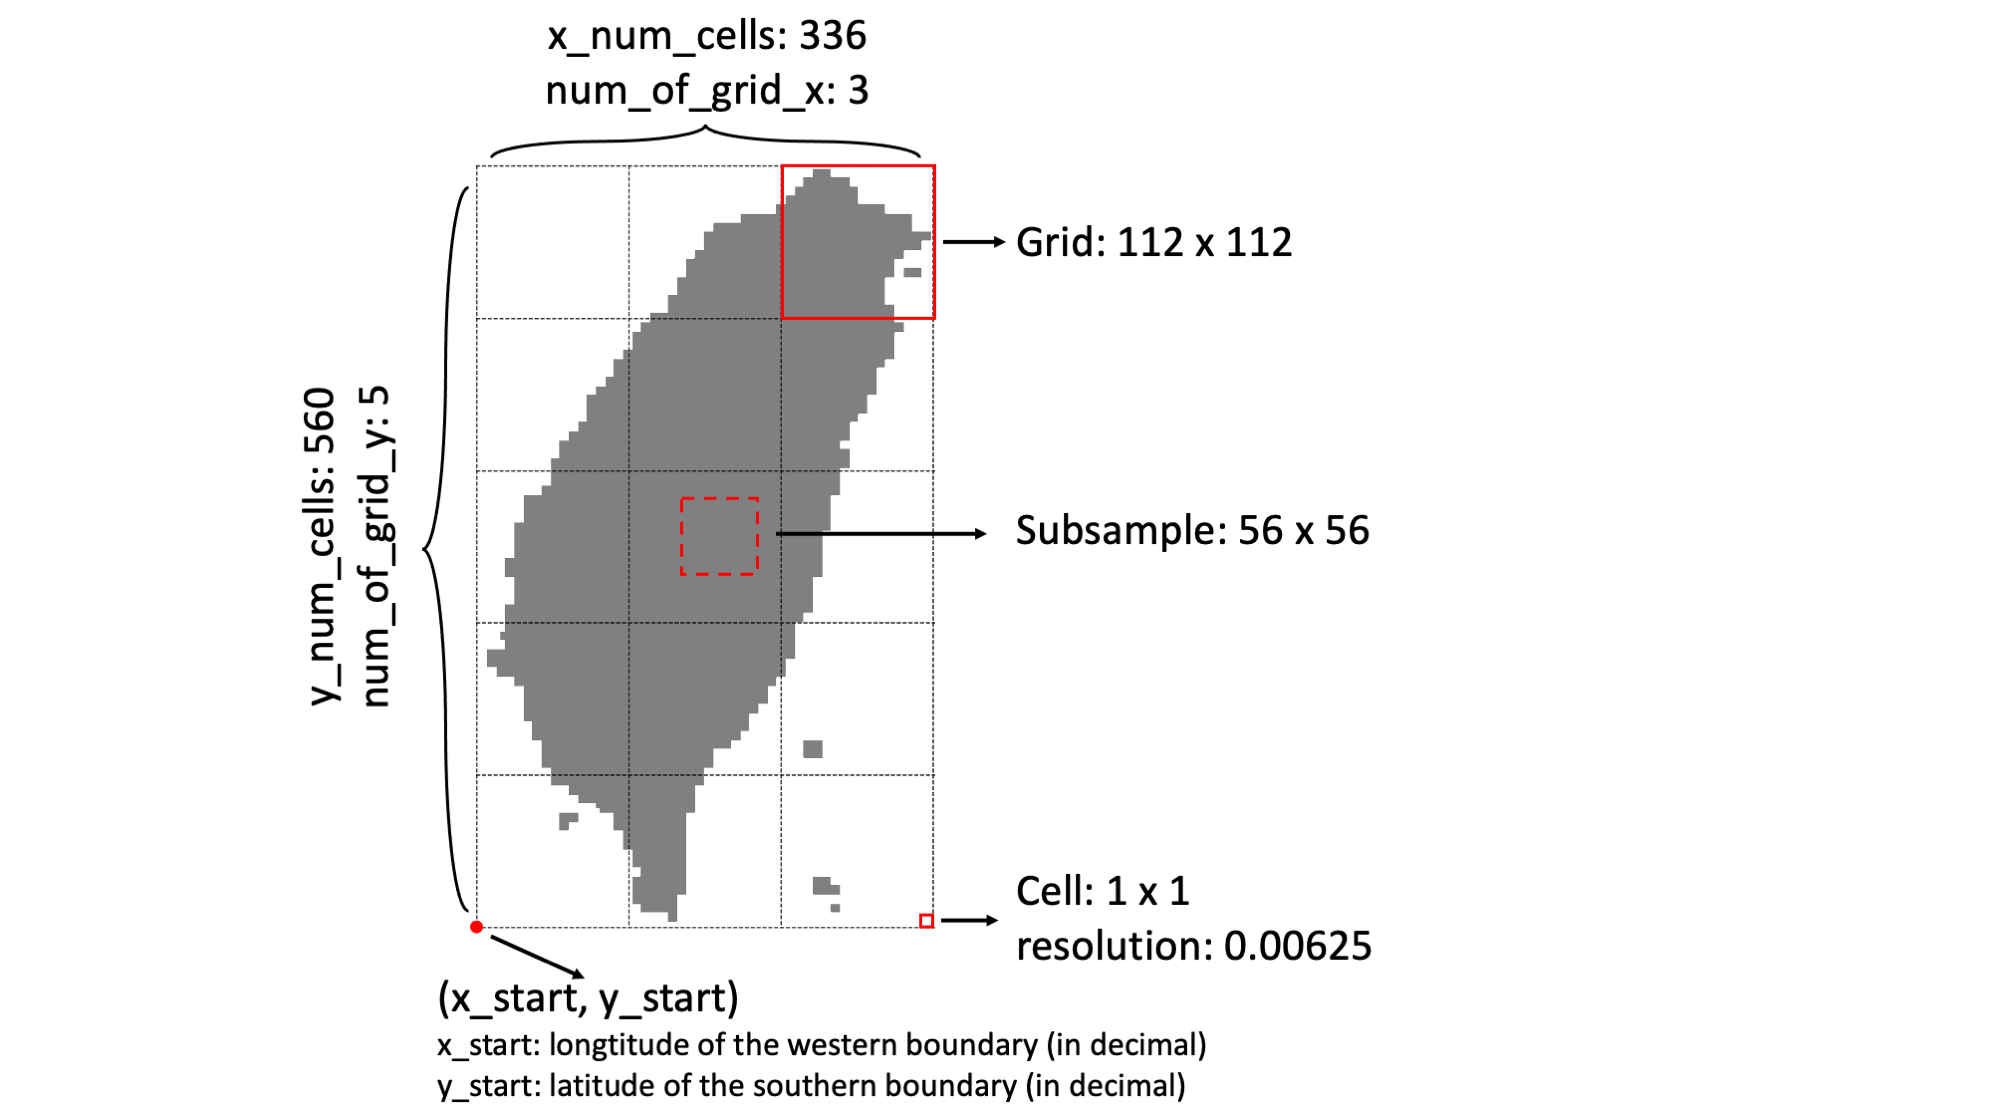

In [2]:
# Our settings
spatial_conf_tmp = SimpleNamespace(**dict(
    x_start = 119.95, # the western bound of longitude  in decimal
    y_start = 21.85, # the southern bound latitude in decimal 
    num_of_grid_x = 3,
    num_of_grid_y = 5,
    grid_size = 112, # number of cells per side of a grid, must >= 56
    out_res = 0.00625 # the decimal coordinates resolution of a cell
))

# other examples
# spatial_conf_tmp = SimpleNamespace(**dict(
#     x_start = 119.5,
#     y_start = 21.5,
#     num_of_grid_x = 3,
#     num_of_grid_y = 4,
#     grid_size = 100, # must >= 56
#     out_res = 0.01, # optional, can be load from example tif
# ))

# spatial_conf_tmp = SimpleNamespace(**dict(
#     x_start = 119.5,
#     y_start = 21.5,
#     num_of_grid_x = 6,
#     num_of_grid_y = 8,
#     grid_size = 100, # must >= 56
#     out_res = 0.005, # optional, can be load from example tif
# ))

### Temporal config

The temporal unit of the training data is the overlapped, consecutive (month_step=1) 3-month (month_span=3) samples.

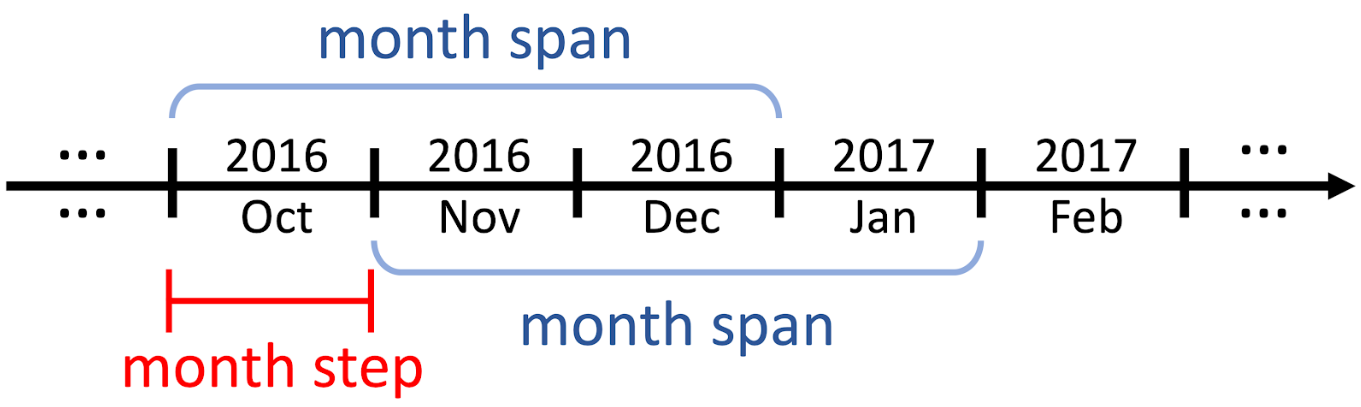

In [3]:
temporal_conf = SimpleNamespace(**dict(
    date_start = '2000-1-1',
    date_end = '2020-12-31',
    month_span = 3,
    month_step = 1,
    cooccurrence_day_limit = 14 # the day span for considered cooccurrence
))

## Preview the geo extent

In [4]:
# init raster helper
raster_helper = RasterHelper()
# generate the geo references with an example environmental tif layer and our spatial configurations
spatial_conf = raster_helper.create_extent_binary_from_env_layer('/home/trashmai/shared/chile/CNN/env_raw/DEM/NASADEM_NC.001_NASADEM_HGT_doy2000042_aid0001.tif', spatial_conf_tmp)
print(spatial_conf)
raster_helper.set_temporal_conf(temporal_conf)

namespace(grid_size=112, num_of_grid_x=3, num_of_grid_y=5, out_res=0.00625, x_end=122.05, x_num_cells=336, x_start=119.95, y_end=25.35, y_num_cells=560, y_start=21.85)


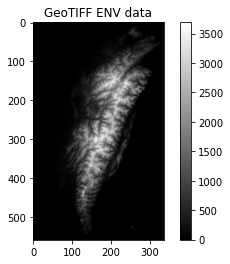

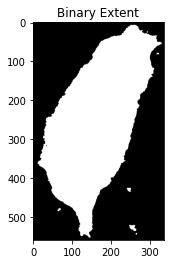

In [5]:
# view the example layer
with rasterio.open('./workspace/extent_env_example.tif') as src:
    # Read the first band (note: some TIFFs may have multiple bands. Adjust as necessary)
    array = src.read(1)
    # Plot the array
    plt.imshow(array, cmap='gray')  # using gray colormap; you can adjust this
    plt.colorbar()
    plt.title('GeoTIFF ENV data')
    plt.show()

# view the binary extent (1, white, cells with env data; 0, black, cells without env data)
with rasterio.open('./workspace/extent_binary.tif') as src:
    # Read the first band (note: some TIFFs may have multiple bands. Adjust as necessary)
    array = src.read(1)
    # Plot the array
    plt.imshow(array, cmap='gray')  # using gray colormap; you can adjust this
    plt.title('Binary Extent')
    plt.show()
    

## Random split train, val grids.

In [6]:
raster_helper.random_split_train_val(train_ratio=0.7)

Partition saved at ./workspace/partition.txt.


## Preview the splits
You can repeat the random split until you get a satisfying split result, or you can modify the output partition.txt file to adjust the arrangement of the train and val grids as you wish.

You can also copy the ./raw/partition.txt we prepared to ./workspace in the demo.
- 0: val
- 1: train

In [7]:
# Uncomment and run following lines to use our partition
import shutil
shutil.copy2('./raw/partition_default.txt', './workspace/partition.txt')

'./workspace/partition.txt'

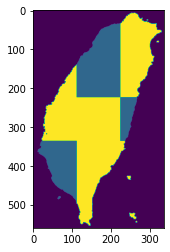

In [8]:
raster_helper.view_train_val_splits()

## We read GBIF occurrence file and make simple data clearance.

We select some essential columns for DeepSDM, and remove rows with empty column(s).
- species
- decimalLatitude, decimalLongitude
- day
- month
- year

In [10]:
cooccur_helper = CooccurrenceHelper(spatial_conf, temporal_conf)

In [18]:
cooccur_helper.filter_occurrence(gbif_occurrence_csv='~/shared/chile/abnielsen/species_occurrence_raw_all.csv')

/home/trashmai/gsmai/DeepSDM/CooccurrenceHelper.py:63: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  self.species_raw = pd.read_csv(self.gbif_occurrence_csv,


File: ./workspace/species_data/occurrence_data/species_occurrence_filter.csv saved.


## Create species rasters that aligned to the geo extent.

In [19]:
raster_helper.set_temporal_conf(temporal_conf)
raster_helper.create_species_raster()

## Create effort-weight rasters for calculating effort-weighted loss.

In [20]:
raster_helper.set_temporal_conf(temporal_conf)
raster_helper.create_k_info()

## Env raster configurations

- The raw env data listed in "env_list" must be put in the ./raw/env/{env} directory.
- The env_no_need_avg indicates those env data that don't change much, e.g. elevation.
- The env_filename_templates describe the file name patterns of each evn. The [YYYY] is the year and the [MM] is the month.
- If your env filename ends with file extension other than 'tif', modify the ext.

In [9]:
env_raw_conf = dict(
    elev = [
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_DTM',
            filename_template = 'G1km_TWD97-121_DTM_ELE.tif',
            env_out_template = 'elev.tif',
        )
    ],
    dem = [
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/DEM',
            filename_template = 'NASADEM_NC.001_NASADEM_HGT_doy2000042_aid0001.tif',
            env_out_template = 'dem.tif',
        )
    ],
    prec = [
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_Climate_2000s',
            filename_template = 'G1km_TWD97-121_Climate_2000s_Prec[MONTH].tif',
            env_out_template = 'prec_2000s_[MONTH].tif',
            year_coverages = [2000, 2009],
        ),
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_Climate_2010s',
            filename_template = 'G1km_TWD97-121_Climate_2010s_Prec[MONTH].tif',
            env_out_template = 'prec_2010s_[MONTH].tif',
            year_coverages = [2010, 2020],
        ),
    ],
    tmin = [
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_Climate_2000s',
            filename_template = 'G1km_TWD97-121_Climate_2000s_Tmin[MONTH].tif',
            env_out_template = 'tmin_2000s_[MONTH].tif',
            year_coverages = [2000, 2009],
        ),
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_Climate_2010s',
            filename_template = 'G1km_TWD97-121_Climate_2010s_Tmin[MONTH].tif',
            env_out_template = 'tmin_2010s_[MONTH].tif',
            year_coverages = [2010, 2020],
        ),
    ],
    tmax = [
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_Climate_2000s',
            filename_template = 'G1km_TWD97-121_Climate_2000s_Tmax[MONTH].tif',
            env_out_template = 'tmax_2000s_[MONTH].tif',
            year_coverages = [2000, 2009],
        ),
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_Climate_2010s',
            filename_template = 'G1km_TWD97-121_Climate_2010s_Tmax[MONTH].tif',
            env_out_template = 'tmax_2010s_[MONTH].tif',
            year_coverages = [2010, 2020],
        ),
    ],
    evi = [
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/EVI',
            filename_template = 'MOD13A1.006__500m_16_days_EVI_doy[YEAR][DOY]_aid0001.tif',
            env_out_template = 'evi_[YEAR]_[MONTH].tif',
        )
    ],
    ndvi = [
        dict(
            raw_env_dir = '/home/trashmai/shared/chile/CNN/env_raw/NDVI',
            filename_template = 'MOD13A1.006__500m_16_days_NDVI_doy[YEAR][DOY]_aid0001.tif',
            env_out_template = 'ndvi_[YEAR]_[MONTH].tif',
        )
    ]
)

## Divide ana align environment rasters according to our spatial and temporal configurations.

In [10]:
raster_helper.set_temporal_conf(temporal_conf)
raster_helper.raw_to_medium(env_raw_conf)

{'raw_env_dir': '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_DTM', 'filename_template': 'G1km_TWD97-121_DTM_ELE.tif', 'env_out_template': 'elev.tif'}
{'raw_env_dir': '/home/trashmai/shared/chile/CNN/env_raw/DEM', 'filename_template': 'NASADEM_NC.001_NASADEM_HGT_doy2000042_aid0001.tif', 'env_out_template': 'dem.tif'}
{'raw_env_dir': '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_Climate_2000s', 'filename_template': 'G1km_TWD97-121_Climate_2000s_Prec[MONTH].tif', 'env_out_template': 'prec_2000s_[MONTH].tif', 'year_coverages': [2000, 2009]}
{'raw_env_dir': '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_Climate_2010s', 'filename_template': 'G1km_TWD97-121_Climate_2010s_Prec[MONTH].tif', 'env_out_template': 'prec_2010s_[MONTH].tif', 'year_coverages': [2010, 2020]}
{'raw_env_dir': '/home/trashmai/shared/chile/CNN/env_raw/GeoTIFF_epsg3826_Climate_2000s', 'filename_template': 'G1km_TWD97-121_Climate_2000s_Tmin[MONTH].tif', 'env_out_template': 'tmin_2000s_[MON

## Averaging rasters according to the time span
3 consecutive months in this example

In [11]:
raster_helper.set_temporal_conf(temporal_conf)
raster_helper.avg_and_mask_env_timespan()

elev
dem
prec
tmin
tmax
evi
******* Warning. Missing data of env:evi on 2000-01.
******* Warning. Data of env: evi on 2000-01 is not available.
ndvi
******* Warning. Missing data of env:ndvi on 2000-01.
******* Warning. Data of env: ndvi on 2000-01 is not available.


## Get cooccurrence embeddings with cooccurrence data

In [11]:
embedding_conf = SimpleNamespace(**dict(
    # batch size
    batch_size = 1000,

    # size of cooccurrence vectors (embedding size)
    num_vector = 64,

    # number of random negative samples
    # number suggestion?
    num_neg = 10,

    # number of epochs
    epochs = 2000
))
cooccur_helper.aggregate_cooccurrence_units(sp_filter_from='./workspace/species_data/occurrence_data/species_occurrence_filter.csv')

Aggregating data costs 15.517326593399048 seconds.


In [12]:
cooccur_helper.count_cooccurrence_mod()

TM = TrainEmbedding(embedding_conf, CreateDataset, EmbeddingModel)
TM.setup()
TM.train()
TM.log_embedding_result()

File: ./workspace/species_data/cooccurrence_data/cooccurrence.csv saved.
Counting cooccurrence costs 2961.066782951355 seconds.
embedding size = (689, 64)
number of data = 112314
batch_size = 1000; num_neg = 10
Early stopped!ss: 1.2125


## Visualize species cooccurrence embeddings

### Exploring embeddings (optional)

You can access the embeddings with TM.embedding, and draw colors along the elevation or categories such as mountain birds and water birds.

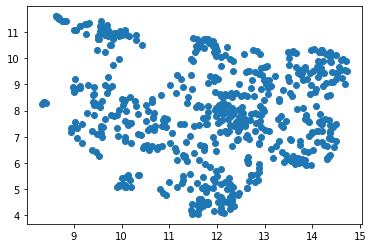

In [11]:
TM.visualize_embedding()

In [71]:
from sklearn.metrics import pairwise_distances
import time
start_time = time.time()
data_unit = cooccur_helper.data_unit
primary_indices = {}
cooccur_counts_df = None
for t in data_unit:
    len_t = max(data_unit)
    for x in data_unit[t]:
        len_x = max(data_unit[t])
        for y in data_unit[t][x]:
            len_y = max(data_unit[t][x])
            print(f'Counting... {t}/{len_t}, {x}/{len_x}, {y}/{len_y}', end='\r')

            obsrvs1 = data_unit[t][x][y]            
            
            neighbor_units = np.array(np.meshgrid([0, 1], [0, 1], [0, 1]), dtype=int).T.reshape(-1, 3)

            for dt, dx, dy in neighbor_units:
                neighbor_t = t + dt
                if neighbor_t not in data_unit:
                    continue

                neighbor_x = x + dx
                if neighbor_x not in data_unit[neighbor_t]:
                    continue

                neighbor_y = y + dy
                if neighbor_y not in data_unit[neighbor_t][neighbor_x]:
                    continue

                obsrvs2 = data_unit[neighbor_t][neighbor_x][neighbor_y]
                
                day_unit_str = f'd{t}-{neighbor_t}'
                spatial_unit_x = f'x{x}-{neighbor_x}' #str(cooccur_satisfied_vals[i][4]*1000 + cooccur_satisfied_vals[i][5])
                spatial_unit_y = f'y{y}-{neighbor_y}' #str(cooccur_satisfied_vals[i][1]*1000 + cooccur_satisfied_vals[i][2])
                data_unit_str = f'{day_unit_str}_{spatial_unit_x}_{spatial_unit_y}'
                
                if data_unit_str in primary_indices:
                    continue
                    
                primary_indices[data_unit_str] = True
                    
                pwd_spatial_satisfied = pairwise_distances(obsrvs1[['decimalLatitude', 'decimalLongitude']], obsrvs2[['decimalLatitude', 'decimalLongitude']]) < cooccur_helper.cooccurrence_xy_limit
                pwd_temporal_satisfied = pairwise_distances(obsrvs1[['day']], obsrvs2[['day']]) < 14
                pwd_satisfied = pwd_spatial_satisfied & pwd_temporal_satisfied
                satisfied_idx = np.where(pwd_satisfied)
                cooccur_satisfied_vals = np.stack([
                    obsrvs1.iloc[satisfied_idx[0]].species.values, 
                    obsrvs2.iloc[satisfied_idx[1]].species.values
                ], axis=1)
                cooccur_satisfied_vals = cooccur_satisfied_vals[cooccur_satisfied_vals[:, 0]!=cooccur_satisfied_vals[:, 1]]
                if cooccur_satisfied_vals.shape[0] > 0:
                    cooccur_satisfied_vals.sort(axis=1)
                    cooccur_local_unique = pd.DataFrame(cooccur_satisfied_vals, columns=['sp1', 'sp2'])
                    cooccur_local_unique_counts = cooccur_local_unique.groupby(['sp1', 'sp2']).size().to_frame('counts').reset_index()
                    if cooccur_counts_df is None:
                        cooccur_counts_df = cooccur_local_unique_counts
                    else:
                        cooccur_counts_df = pd.concat([cooccur_counts_df, cooccur_local_unique_counts])

    cooccur_counts_df = cooccur_counts_df.groupby(['sp1', 'sp2']).sum().reset_index()
                        
#             if obsrvs is not None:
#                 triu1_idx = np.triu_indices(obsrvs.shape[0], 1)
#                 pwd_satisfied = (pairwise_distances(obsrvs[['decimalLatitude', 'decimalLongitude']]) < 0.0125) & (pairwise_distances(obsrvs[['day']]) < 14)
#                 satisfied_idx = np.where(pwd_satisfied[triu1_idx])[0]

#                 occur_1 = obsrvs.iloc[triu1_idx[0]][['species', 'day', 'decimalLatitudeUnit', 'decimalLongitudeUnit']].rename({'species':'sp1', 'decimalLatitudeUnit':'ulat1', 'decimalLongitudeUnit':'ulng1'}, axis=1).reset_index(drop=True)
#                 occur_2 = obsrvs.iloc[triu1_idx[1]][['species', 'day', 'decimalLatitudeUnit', 'decimalLongitudeUnit']].rename({'species':'sp2', 'decimalLatitudeUnit':'ulat2', 'decimalLongitudeUnit':'ulng2'}, axis=1).reset_index(drop=True)

#                 cooccur_df = pd.concat([occur_1, occur_2], axis=1)
#                 cooccur_satisfied_vals = cooccur_df.iloc[satisfied_idx].query('sp1 != sp2').values

# #                 cooccur_satisfied_df = cooccur_satisfied_df_.query('sp1 != sp2').reset_index(drop=True)
# #                 cooccur_satisfied_vals = cooccur_satisfied_df.values

#                 sp1s = []
#                 sp2s = []
#                 for i in range(cooccur_satisfied_vals.shape[0]):
#                     sp_pair = cooccur_satisfied_vals[i][[0, 4]]
#                     sp_pair.sort()
#                     # sp_pair_str = '-'.join(sp_pair)
#                     day_unit_str = f'd{cooccur_satisfied_vals[i][1]}-{cooccur_satisfied_vals[i][5]}'
#                     spatial_unit_x = f'x{cooccur_satisfied_vals[i][3]}-{cooccur_satisfied_vals[i][7]}' #str(cooccur_satisfied_vals[i][4]*1000 + cooccur_satisfied_vals[i][5])
#                     spatial_unit_y = f'y{cooccur_satisfied_vals[i][2]}-{cooccur_satisfied_vals[i][6]}' #str(cooccur_satisfied_vals[i][1]*1000 + cooccur_satisfied_vals[i][2])
#                     data_unit_str = f'{day_unit_str}_{spatial_unit_x}_{spatial_unit_y}'
#                     # pkey = sp_pair_str + '_' + spatial_unit_str
#                     pkey = data_unit_str
#                     if pkey not in primary_indices:
#                         primary_indices[pkey] = True
#                         sp1s.append(sp_pair[0])
#                         sp2s.append(sp_pair[1])

#                 if len(sp1s) > 0:
#                     cooccur_local_unique = pd.DataFrame({'sp1': sp1s, 'sp2': sp2s})
#                     cooccur_local_unique_counts = cooccur_local_unique.groupby(['sp1', 'sp2']).size().to_frame('counts').reset_index()

#                     if cooccur_counts_df is None:
#                         cooccur_counts_df = cooccur_local_unique_counts
#                     else:
#                         cooccur_counts_df = pd.concat([cooccur_counts_df, cooccur_local_unique_counts])
#     cooccur_counts_df = cooccur_counts_df.groupby(['sp1', 'sp2']).sum().reset_index()

KeyboardInterrupt: 